<a href="https://colab.research.google.com/github/LinCheungS/MUN_Paper_2020/blob/master/PatchCamelyon_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data from kaggle

In [0]:
!pip install -q kaggle
!mkdir .kaggle
import json
token = {"username":"lincheung","key":"xxxxxx"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle competitions download -c histopathologic-cancer-detection -p /content

In [0]:
mkdir train_image
mkdir test_image
!unzip -q -d /content/train_image/ train.zip
!unzip -q -d /content/test_image/ test.zip
!unzip train_labels.csv.zip
!unzip sample_submission.csv.zip

In [0]:
import os

In [0]:
len(os.listdir('/content/train_image/'))

220025

In [0]:
len(os.listdir('/content/test_image/'))

57458

# Data cleaning and visualization

## GPU situation

In [0]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau

from skimage import io
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6465017461902179854
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15595722607391175962
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10642094867286888664
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4561040696500381339
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
df_train = pd.read_csv('train_labels.csv')
df_train.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


## Predicted value distribution

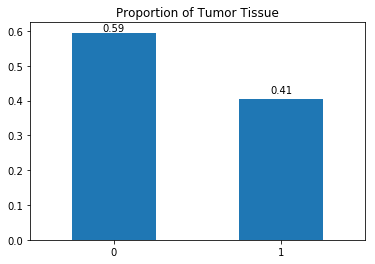

In [0]:
df_train['label'].value_counts(normalize=True).plot.bar(rot=0)

plt.title('Proportion of Tumor Tissue')

#Add labels
x = list(round(df_train['label'].value_counts(normalize=True), 2).index)
y = round(df_train['label'].value_counts(normalize=True), 2)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

## load data set

In [0]:
train_files = glob('train_image/*.tif')
test_files = glob('test_image/*.tif')
print("训练数据 :", len(train_files))
print("测试数据 :", len(test_files))

训练数据 : 220025
测试数据 : 57458


## Picture visualization

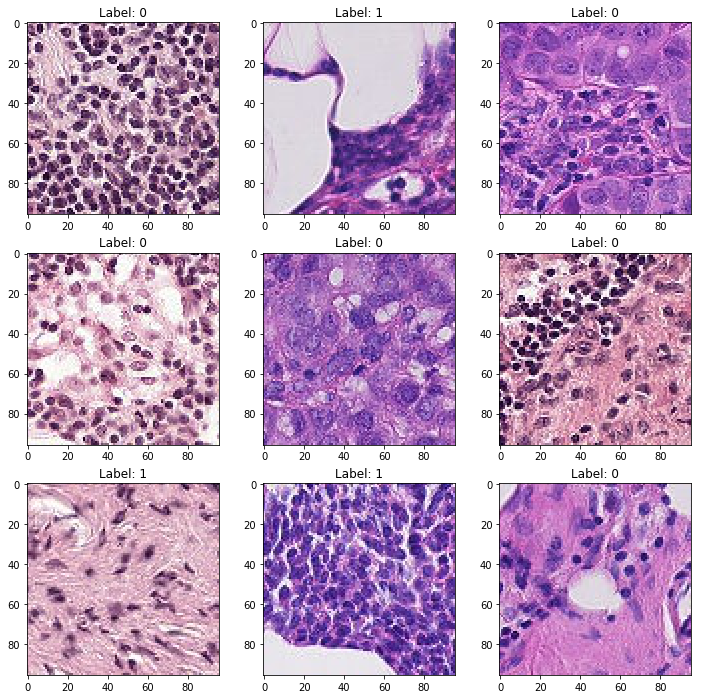

In [0]:
plt.figure(figsize=(12,12))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(io.imread('train_image/{}.tif'.format(df_train.id[i+30])))
    plt.title('Label: {}'.format(df_train.label[i]))

(96, 96, 3)


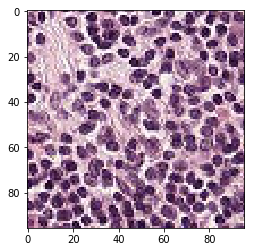

In [0]:
example = io.imread('train_image/{}.tif'.format(df_train.id[30]))
print(example.shape)
plt.imshow(example)

# Training

In [0]:

# Initialising the CNN
model = Sequential()

# First set of convolution layers
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))

# Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# Second set of convolutional layer
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Add Dropout to prevent over fitting
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Full connection
model.add(Dense(units = 128, activation = 'relu'))

# Add Dropout to prevent over fitting
model.add(Dropout(0.5))

model.add(Dense(units = 1, activation = 'sigmoid', name = 'pred'))

model.summary()

W0619 15:19:42.754545 140260898535296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 15:19:42.764247 140260898535296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 15:19:42.778954 140260898535296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 15:19:42.834225 140260898535296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0619 15:19:42.904835 140260898535296 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 128)       0         
__________

In [0]:
df_train["id"] = df_train["id"].map(lambda code: code[:]+".tif")

In [0]:
# Image augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   channel_shift_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   validation_split = 0.25)

test_datagen = ImageDataGenerator(rescale = 1./255)

df_train['label'] = df_train['label'].astype(str)
df_train['id'] = df_train['id'].astype(str)

#Split train data
train_set = train_datagen.flow_from_dataframe(dataframe = df_train,
                                              directory = 'train_image',
                                              x_col = 'id',
                                              y_col = 'label',
                                              has_ext = False,
                                              target_size = (96, 96),
                                              batch_size = 64,
                                              class_mode = 'binary',
                                              subset = 'training')

eval_set = train_datagen.flow_from_dataframe(dataframe = df_train,
                                            directory = 'train_image',
                                            x_col = 'id',
                                            y_col = 'label',
                                            has_ext = False,
                                            target_size = (96, 96),
                                            batch_size = 64,
                                            class_mode = 'binary',
                                            subset = 'validation',
                                            shuffle = False)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [0]:
#Calculate steps for model training
train_steps = train_set.n//train_set.batch_size
eval_steps = eval_set.n//eval_set.batch_size

print(train_steps)
print(eval_steps)

2578
859


In [0]:

filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

#Callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 1, restore_best_weights=True)

reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 1, cooldown = 1)

csvlogger = CSVLogger(filename = "training_csv.log", separator = ",", append = False)

In [0]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

W0619 15:20:07.289395 140260898535296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0619 15:20:07.333413 140260898535296 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0619 15:20:07.341867 140260898535296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Model Training
hist = model.fit_generator(train_set,
                    steps_per_epoch = train_steps,
                    epochs = 20,
                    validation_data = eval_set,
                    validation_steps = eval_steps,
                    callbacks = [checkpoint, reduce, csvlogger])

Epoch 1/20
2578/2578 [==============================] - 1010s 392ms/step - loss: 0.4449 - acc: 0.8007 - val_loss: 0.3570 - val_acc: 0.8441

Epoch 00001: val_acc improved from -inf to 0.84410, saving model to weights-improvement-01-0.84.hdf5
Epoch 2/20
2578/2578 [==============================] - 957s 371ms/step - loss: 0.3555 - acc: 0.8483 - val_loss: 0.3320 - val_acc: 0.8556

Epoch 00002: val_acc improved from 0.84410 to 0.85556, saving model to weights-improvement-02-0.86.hdf5
Epoch 3/20
2578/2578 [==============================] - 929s 360ms/step - loss: 0.3242 - acc: 0.8658 - val_loss: 0.3006 - val_acc: 0.8732

Epoch 00003: val_acc improved from 0.85556 to 0.87323, saving model to weights-improvement-03-0.87.hdf5
Epoch 4/20
2578/2578 [==============================] - 878s 341ms/step - loss: 0.3011 - acc: 0.8770 - val_loss: 0.2765 - val_acc: 0.8875

Epoch 00004: val_acc improved from 0.87323 to 0.88748, saving model to weights-improvement-04-0.89.hdf5
Epoch 5/20
2578/2578 [========

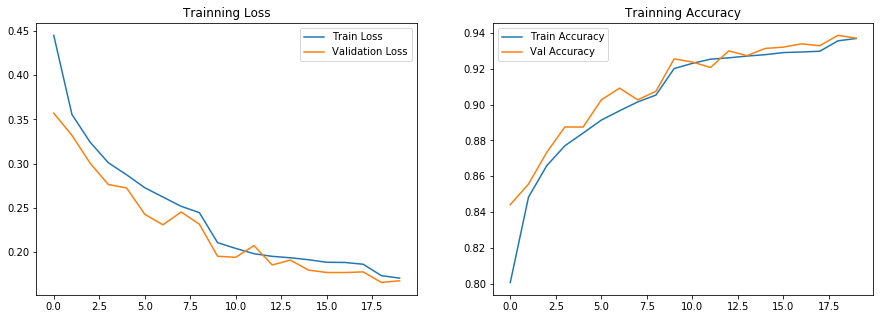

In [0]:
plt.figure(figsize=(15, 5))
#Plot Trainning loss
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, hist.history['loss'], label = 'Train Loss')
plt.plot(hist.epoch, hist.history['val_loss'], label = 'Validation Loss')
plt.title('Trainning Loss')
plt.legend()

#Plot Trainning Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.epoch, hist.history['acc'], label = 'Train Accuracy')
plt.plot(hist.epoch, hist.history['val_acc'], label = 'Val Accuracy')
plt.title('Trainning Accuracy')
plt.legend()